In [1]:
# analyze raw pose estimation from vertical videos only and get gait metrics

# required folder structure of input folder (raw_pose_data_in_path, mirrors video folder structure)
# raw_pose_data_in_path
    # participant 1
        # date 
            # 000_raw_pose_data (folder containing pose, world, and yolo raw pose data .csv files) 
    # BW-12 
        # 2024-05-02  
            # 000_raw_pose_data (folder containing pose, world, and yolo raw pose data .csv files)

#  outputs from this analysis script will be saved in the same folder 

#raw_pose_data_in_path
    # participant 1
        # date 
            # 001 analysis results 
            # 002 analysis results 

# note! if more than three videos for each task, need to update 'task' variable below to include 'gait_vertical_left_3' etc 

# try for no spaces in folder and file names, but should still work if there are spaces 

In [2]:
# import libraries 
import pandas as pd 
import numpy as np 
import os 
import re

In [3]:
# import functions from sandbox src code files 
from raw_pose_analysis_funs.merge_mp_yolo_dfs import (merge_mp_pose_world, clean_mp_yolo_missing_data, add_orientation_and_turn_direction, save_merge_mp_yolo_df)
from raw_pose_analysis_funs.frames_to_time import (add_time_column, save_df_w_time)
from raw_pose_analysis_funs.landmark_visibility import (mp_vis_all_labels_boxplot, mp_vis_lineplot, mp_save_vis_stats_by_label, yolo_vis_lineplot)
from raw_pose_analysis_funs.segment_video_walk_turn import (segment_video_interp_filter, segment_video_walks_turn)
from raw_pose_analysis_funs.gait_metric_stride_time import(stride_time_interp, calculate_stride_time)
from raw_pose_analysis_funs.gait_metric_cadence import (calculate_cadence)
from raw_pose_analysis_funs.gait_metric_stride_width import (stride_width_interp, calculate_stride_width)
from raw_pose_analysis_funs.gait_metric_support import (support_interp, support_filter_lowpass,id_toe_off_heel_strike)

In [8]:
# set variables in advance 

# Set input path to run all analysis 
# folder with all raw pose data (dir_in_path) 
raw_pose_data_in_path = r'C:\Users\mmccu\Box\MM_Personal\5_Projects\BoveLab\3_Data_and_Code\test_new_output_folders'
# input variables for segment toward and away functions 
max_gap = 0.12 # max gap to interpolate over 
cutoff = 0.4
order = 1


In [9]:
# save list of all csv files in raw pose data folders 

raw_data_full_path_all = [] 
raw_data_file_names_all = []

# loop through all files in input path 
for (dir_path, dir_names, file_names) in os.walk(raw_pose_data_in_path):
    for file_name in file_names: 
        name, ext = os.path.splitext(file_name)
        ext = ext.lower()[1:]
        current_raw_data_in_path = os.path.join(dir_path, file_name) # full path to files 
        # save full path to file if it meets requirements to be raw pose data 
        if (ext == 'csv') & ('000_raw_pose_data' in current_raw_data_in_path): # from run.py, outputs all saved in 000_raw_pose_data_folder
            raw_data_full_path_all = raw_data_full_path_all + [current_raw_data_in_path]
            raw_data_file_names_all = raw_data_file_names_all + [file_names]

In [10]:
# find all unique ID date combos (each unique folder with videos)

id_date_all = []
for file_i, raw_path in enumerate(raw_data_full_path_all): 
    parent_path_1, current_file_name = os.path.split(raw_path)
    parent_path_2, current_raw_data_folder = os.path.split(parent_path_1)
    parent_path_3, current_date = os.path.split(parent_path_2)
    parent_path_4, current_id = os.path.split(parent_path_3)
    current_id_date = os.path.join(current_id, current_date)
    id_date_all = id_date_all + [current_id_date]


Analyzing data from: DS_HC\2024-05-02
dir_out_prefix: C:\Users\mmccu\Box\MM_Personal\5_Projects\BoveLab\3_Data_and_Code\test_new_output_folders\DS_HC\2024-05-02
video_id_date_name: gait_vertical_left_DS_HC_2024-05-02
Skipped: no files matching gait_vertical_left_2
Skipped: no files matching gait_vertical_left_3
video_id_date_name: gait_vertical_right_DS_HC_2024-05-02
Skipped: no files matching gait_vertical_right_2
Skipped: no files matching gait_vertical_right_3
Skipped: no files matching gait_vertical_PWS_1
Skipped: no files matching gait_vertical_PWS_2
Skipped: no files matching gait_vertical_FW_1
Skipped: no files matching gait_vertical_FW_2
Skipped: no files matching gait_vertical_TUG_1
Skipped: no files matching gait_vertical_TUG_2
Analyzing data from: MM_HC\2024-07-30
dir_out_prefix: C:\Users\mmccu\Box\MM_Personal\5_Projects\BoveLab\3_Data_and_Code\test_new_output_folders\MM_HC\2024-07-30
Skipped: no files matching gait_vertical_left
Skipped: no files matching gait_vertical_left

IndexError: positional indexers are out-of-bounds

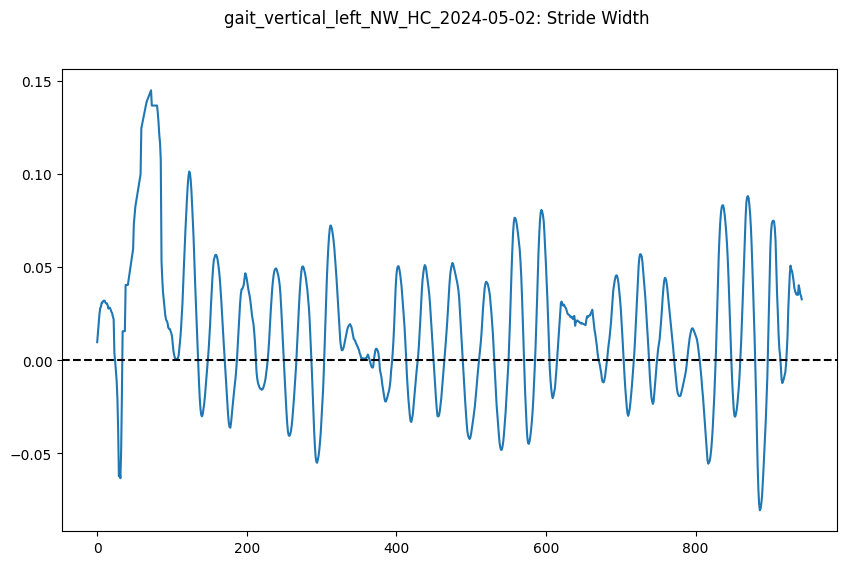

In [12]:
# for each unique ID and date combo, 
#select either all gait_vertical_right .csv files or all gait_vertical_left files and run all analysis 

# all unique ID and date combos of .csv files in raw pose data folder 
unique_id_date = list(set(id_date_all))
unique_id_date = sorted(unique_id_date) # run in same order every time

# gait_vertical_left and gait_vertical_right = home videos 
# PWS, FW, and TUG = in person BW zeno videos 
tasks = ['gait_vertical_left', 
         'gait_vertical_left_2', 
         'gait_vertical_left_3',
         'gait_vertical_right', 
         'gait_vertical_right_2',
         'gait_vertical_right_3',
         'gait_vertical_PWS_1',
         'gait_vertical_PWS_2',
         'gait_vertical_FW_1', 
         'gait_vertical_FW_2',
         'gait_vertical_TUG_1',
         'gait_vertical_TUG_2'
        ] 

for id_date_i, id_date in enumerate(unique_id_date): 
    print('Analyzing data from: ' + id_date)
    # select raw data paths that match id_date combo 
    current_id_date_csv_file_paths = [item for item in raw_data_full_path_all if id_date in item]
    
    # set output folder prefix. Find relative paths relative from input folder to raw data .csv 
    raw_data_relpath = os.path.relpath(current_id_date_csv_file_paths[1], raw_pose_data_in_path)
    rel_path_to_date_subfolder, raw_data_subfolder = os.path.split(os.path.dirname(raw_data_relpath))
    dir_out_prefix = os.path.normpath(os.path.join(raw_pose_data_in_path, rel_path_to_date_subfolder))
    print('dir_out_prefix: ' + dir_out_prefix)
    
    # select raw data paths that match right or left vertical task 
    for task_i, task, in enumerate(tasks):  
        
        # select files matching current task 
        current_task_csv_paths = [item for item in current_id_date_csv_file_paths if task in item]
        
        # if files with raw data for this task is saved in subfolder, run analysis  
        if len(current_task_csv_paths) == 0: 
            print('Skipped: no files matching ' + task)
        elif len(current_task_csv_paths) > 0:   
            
            # after selecting for correct task, save each raw data path as own variable 
            current_yolo_data_path = [item for item in current_task_csv_paths if 'yolo.csv' in item]
            current_mp_pose_data_path = [item for item in current_task_csv_paths if 'mediapipe.csv' in item]
            current_mp_world_data_path = [item for item in current_task_csv_paths if 'mediapipe_world.csv' in item]
            # save video frames per second (fps) file path
            current_video_fps_path = [item for item in current_task_csv_paths if 'fps.csv' in item]
            
            # read in raw pose data, all three types 
            mp_pose_df = pd.read_csv(current_mp_pose_data_path[0])
            mp_world_df = pd.read_csv(current_mp_world_data_path[0])
            yolo_df = pd.read_csv(current_yolo_data_path[0])
            
            # read in frames per seconds and save as var for future code 
            fps_df = pd.read_csv(current_video_fps_path[0], index_col = 0)
            fps = fps_df.iloc[0,0]

            # set video ID - ID_date_task (analogous to vid_in_path in run script, use for plot and file names)
            yolo_basename = os.path.splitext(os.path.basename(current_yolo_data_path[0]))[0]
            video_id_date_name = (yolo_basename).replace('yolo', id_date).replace('\\', '_')
            print('video_id_date_name: ' + video_id_date_name)
        
            # run analysis functions 
            # step 001 - save updated .csv files in 001 output folder 
            [mp_all_df, yolo_df] = merge_mp_pose_world(mp_pose_df, mp_world_df, yolo_df)
            [mp_all_df, yolo_df] = clean_mp_yolo_missing_data(mp_all_df, yolo_df)
            [mp_all_df, yolo_df] = add_orientation_and_turn_direction(video_id_date_name, mp_all_df, yolo_df) # check vid_in_path 
            save_merge_mp_yolo_df(mp_all_df, yolo_df, video_id_date_name, dir_out_prefix)

            # 002 frames to time: save .csv file with seconds in 003 output folder 
            [mp_all_df, yolo_df] = add_time_column(mp_all_df, yolo_df, fps)
            save_df_w_time(mp_all_df, yolo_df, video_id_date_name, dir_out_prefix)

            # 003 - plot and save landmark visibility scores for yolo and mediapipe 
            # yolo 
            yolo_vis_lineplot(yolo_df, video_id_date_name, dir_out_prefix)
            # mediapipe 
            mp_vis_all_labels_boxplot(mp_all_df, video_id_date_name, dir_out_prefix) 
            mp_vis_lineplot(mp_all_df, video_id_date_name, dir_out_prefix)
            # calculate and save mean, standard deviation, and median visibility for each marker
            vis_stats_df = mp_save_vis_stats_by_label(mp_all_df, video_id_date_name, dir_out_prefix)

            # 004 - segment walking toward camera, away from camera, or turning based on hip positions
            # interpolate and filter mp hip Z position, L and R 
            # interpolate yolo hip X position, L and R 
            [mp_hip_z_filt, yolo_hip_x_interp] = segment_video_interp_filter(mp_all_df,
                                                                             yolo_df, 
                                                                             video_id_date_name, 
                                                                             dir_out_prefix, 
                                                                             max_gap, 
                                                                             fps, 
                                                                             cutoff, 
                                                                             order)
            # using interpolated and filtered data, ID toward, away, or turn
            # save plots and .csv files 
            [turn_df, walks_df] = segment_video_walks_turn(mp_hip_z_filt, yolo_hip_x_interp, video_id_date_name, dir_out_prefix, fps,
                                               find_peaks_distance = 200, # min distance between hip z distance peaks (frames) 
                                               find_peaks_prominence = 0.2, # hip Z peaks need to be greater than this value to count as a turn
                                               flattening_point_atol = 0.0025, # Distance of hip z diff away from zero to be identified as "flattening point"
                                               dist_turn_mid_to_flattening = 20) # flattening point has to be at least this many frames from turn midpoint

            #005 calculate gait metrics 
            # stride time 
            mp_ankle_Y_interp = stride_time_interp(mp_all_df,video_id_date_name, dir_out_prefix, max_gap, fps)
            [stride_time_stats_df, stride_times_peaks, stride_times_valleys] = calculate_stride_time(mp_ankle_Y_interp, fps, 
                                                                                                     video_id_date_name, dir_out_prefix,
                                                                                                     find_peaks_distance = 5, # min distance between ankle y distance peaks (frames) 
                                                                                                     find_peaks_prominence = 0.01) # ankle y peaks need to be greater than this value to count as step

            # cadence 
            [total_steps, video_length_sec, cadence] = calculate_cadence(stride_times_peaks, stride_times_valleys, 
                                                                         fps, mp_all_df, 
                                                                         video_id_date_name, dir_out_prefix)

            # stride width 
            mp_stride_width_interp_dfs = stride_width_interp(mp_all_df, video_id_date_name, dir_out_prefix, max_gap, fps)
            stride_width_stats_df = calculate_stride_width(mp_stride_width_interp_dfs, video_id_date_name, dir_out_prefix)

            # double and single support 
           # toe_off_heel_strike = id_toe_off_heel_strike(yolo_df, video_id_date_name, dir_out_prefix, max_gap, fps, cutoff, order)
            